In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from discretize_sepsis_actions import discretize_actions
import pickle
%matplotlib inline  

# Preparation

In [61]:
# load data
data = pd.read_csv("/Users/dilys/Desktop/Harvard_1718_Fall/CS282/Homework/HW3/P2/Sepsis_imp.csv")
states = np.loadtxt("/Users/dilys/Desktop/Harvard_1718_Fall/CS282/Homework/HW3/P2/states_list.csv")

In [3]:
# Discretize action
actions, \
input_4hourly__conversion_from_binned_to_continuous, \
median_dose_vaso__conversion_from_binned_to_continuous \
= discretize_actions(data['input_4hourly_tev'], data['median_dose_vaso'], bins_num = 5)
vaso = np.array(list(median_dose_vaso__conversion_from_binned_to_continuous) * 5)
fluid = np.repeat(input_4hourly__conversion_from_binned_to_continuous, 5)

In [4]:
icustayid = data['icustayid']
death = data['died_in_hosp']
rewards = np.zeros((data.shape[0])); rewards.fill(-1)
d = {'id': icustayid.astype('int'),\
     's':states.astype('int'),\
     'a': actions.astype('int'),\
     'r': rewards.astype('int'),
     'd': death.astype('int')
}
subdata = pd.DataFrame(d, columns = ['id','s','a','r','d'])
patients  = icustayid.unique()

In [5]:
Episodes= {}
j = 0
for i in patients:
    temp = subdata[subdata['id'] == i]
    T = len(temp)
    history = np.zeros((T, 5))
    
    s1 = temp['s'].iloc[T-1]
    a = temp['a'].iloc[T-1]
    if temp['d'].iloc[-1] == 0:
        s2 = 2000
        r = 50
    else:
        s2 = 2001
        r = -50
    history[T-1] = np.array([T-1, s1, a, s2, r])
    
    if T ==1:
        continue
    
    for t in range(T - 1 ):
        s1 = temp['s'].iloc[t]
        a = temp['a'].iloc[t]
        s2 = temp['s'].iloc[t + 1]
        r = temp['r'].iloc[t]
        
        history[t] = np.array([t, s1, a, s2, r])
        
    Episodes[j] = pd.DataFrame(history, columns = ['T','S1','A','S2','R'])
    j = j+ 1
    if j%1000 == 0:
        print j*1.0/len(patients)

0.0518806744488
0.103761348898
0.155642023346
0.207522697795
0.259403372244
0.311284046693
0.363164721141
0.41504539559
0.466926070039
0.518806744488
0.570687418936
0.622568093385
0.674448767834
0.726329442283
0.778210116732
0.83009079118
0.881971465629
0.933852140078


In [7]:
pickle.dump(Episodes, open('Episodes.pkl', 'wb'))

# Functions for SARSA and Q_Learning

In [32]:
# Update the Q table 
def update_Q_SARSA( Q_table, state, action, reward, new_state, new_action, gamma = 0.95, alpha = 0.1):
    # FILL THIS IN 
    state = int(state); action = int(action); new_state = int(new_state); new_action = int(new_action)
    Q_table[state,action] = Q_table[state,action] + alpha * ((reward + gamma * Q_table[new_state,new_action]) - Q_table[state,action])

    return Q_table 

# Update the Q table 
def update_Q_Qlearning( Q_table, state, action, reward, new_state, new_action, gamma = 0.95, alpha = 0.1):
    # FILL THIS IN 
    state = int(state); action = int(action); new_state = int(new_state); new_action = int(new_action)
    max_action = np.argmax( Q_table[new_state , : ] )
    Q_table[state,action] = Q_table[state,action] + alpha * ((reward + gamma * Q_table[new_state,max_action]) - Q_table[state,action])

    return Q_table 


In [53]:
# Functions for geting the optimal policy
def get_Optimal_Policy(Q_table):
    optimal_policy = np.zeros(Q_table.shape)
    for i in range(len(Q_table)):
        optimal_policy[i, np.argmax(Q_table[i,])] = 1
    return optimal_policy

# SARSA and Q_Learning

In [18]:
Episodes = pickle.load(open('Episodes.pkl', 'rb'))

In [40]:
Q_table_SARSA = np.zeros((2002, 25))
Q_table_Qlearning = np.zeros((2002, 25))

count = 0
for epi in Episodes.keys():
    count = count + 1
    if (count%1000 == 1):
        print '{}% finished'.format(round(100.0*count/len(Episodes),2))
    
    data = Episodes[epi]
    for t in range(len(data)):
        state = data.ix[t,'S1']
        action = data.ix[t, 'A']
        reward = data.ix[t, 'R']
        new_state = data.ix[t, 'S2']
        
        if t < len(data) -1:
            new_action = data.ix[t+1, 'A']
        else:
            new_action = np.random.choice(25)
        
        Q_table_SARSA = update_Q_SARSA( Q_table_SARSA, state, action, reward, new_state, new_action)
        Q_table_Qlearning = update_Q_Qlearning( Q_table_Qlearning, state, action, reward, new_state, new_action)
print '100% finished'

0.01% finished
5.29% finished
10.58% finished
15.87% finished
21.15% finished
26.44% finished
31.73% finished
37.01% finished
42.3% finished
47.59% finished
52.88% finished
58.16% finished
63.45% finished
68.74% finished
74.02% finished
79.31% finished
84.6% finished
89.89% finished
95.17% finished
100% finished


In [54]:
optimal_policy_SARSA = get_Optimal_Policy(Q_table_SARSA)
optimal_policy_Qlearning = get_Optimal_Policy(Q_table_Qlearning)

In [67]:
def Compute_Deviation(policy):
    policy_vaso = np.sum(policy*vaso, axis = 1)[states.astype('int')]
    policy_fluid = np.sum(policy*fluid, axis = 1)[states.astype('int')]
    temp = {'icustayid':icustayid,
        'death': death,
        'vaso': data['median_dose_vaso'].values,
        'fluid': data['input_4hourly_tev'].values,
        'action': actions,
        'policy_vaso': policy_vaso,
        'policy_fluid': policy_fluid,
        'vaso_dev': policy_vaso - data['median_dose_vaso'].values,
        'fluid_dev': policy_fluid - data['input_4hourly_tev'].values    
        }
    temp = pd.DataFrame(temp, columns = ['icustayid', 'death', 'vaso', \
                                     'fluid', 'action', 'policy_vaso',\
                                    'policy_fluid', 'vaso_dev', 'fluid_dev'])
    vaso_dev_mean = temp.groupby(by="icustayid")['vaso_dev'].mean().values
    fluid_dev_mean = temp.groupby(by="icustayid")['fluid_dev'].mean().values
    outcome = temp.groupby(by="icustayid")['death'].mean().values
    result = {'vaso_dev':temp['vaso_dev'],
              'vaso_dev_mean':vaso_dev_mean, 
              'fluid_dev':temp['fluid_dev'], 
              'fluid_dev_mean': fluid_dev_mean
    }
    
    return result

In [68]:
SARSA = Compute_Deviation(optimal_policy_SARSA)
Q_Learning = Compute_Deviation(optimal_policy_Qlearning)

In [74]:
def get_bins(devs, death, var):
    d_bins = {'vaso': np.linspace(-5,3,59),
              'fluid':range(-10000,1000,200)  
    }
    
    bins = d_bins[var]
    temp_dead = devs[death == 1]
    temp_surv = devs[death == 0]
    
    a, _ = np.histogram(temp_dead, bins)
    b, _ = np.histogram(temp_surv, bins)
    
    m = a*1.0/(a+b) 
    midpoint = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    
    result = {'mortality': m,
              'dev': midpoint   
    }
  

    return result

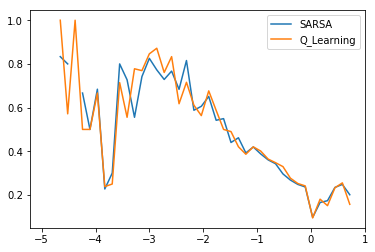

In [80]:
Draw_SARSA = get_bins(SARSA['vaso_dev'], death, 'vaso')
Draw_Qlearning = get_bins(Q_Learning['vaso_dev'], death, 'vaso')
plt.plot(Draw_SARSA['dev'], Draw_SARSA['mortality'], label = 'SARSA')
plt.plot(Draw_Qlearning['dev'], Draw_Qlearning['mortality'], label = 'Q_Learning')
plt.legend()

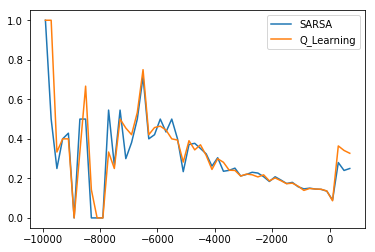

In [81]:
Draw_SARSA = get_bins(SARSA['fluid_dev'], death, 'fluid')
Draw_Qlearning = get_bins(Q_Learning['fluid_dev'], death, 'fluid')
plt.plot(Draw_SARSA['dev'], Draw_SARSA['mortality'], label = 'SARSA')
plt.plot(Draw_Qlearning['dev'], Draw_Qlearning['mortality'], label = 'Q_Learning')
plt.legend()

# Bootstrap Confidence Interval

In [105]:
def get_Q_table(Episodes):
    # Episodes is a dictionary
    # element in Episode is a dataframe, with t, S1, A, R, S2
    Q_table_SARSA = np.zeros((2002, 25))
    Q_table_Qlearning = np.zeros((2002, 25))

    for epi in Episodes.keys():
        data = Episodes[epi]
        for t in range(len(data)):
            state = data.ix[t,'S1']
            action = data.ix[t, 'A']
            reward = data.ix[t, 'R']
            new_state = data.ix[t, 'S2']

            if t < len(data) -1:
                new_action = data.ix[t+1, 'A']
            else:
                new_action = np.random.choice(25)

            Q_table_SARSA = update_Q_SARSA( Q_table_SARSA, state, action, reward, new_state, new_action)
            Q_table_Qlearning = update_Q_Qlearning( Q_table_Qlearning, state, action, reward, new_state, new_action)
    result = {'SARSA': Q_table_SARSA,
             'Q_Learning': Q_table_Qlearning}
    return(result)

In [106]:
B_times = 100
Bootstrap_Q_table = {'SARSA': np.zeros((2002,25,B_times)),
                    'Q_Learning': np.zeros((2002,25,B_times))}

for i in range(B_times):
    print i
    # choose bootstrap samples
    to_choose = np.random.choice(Episodes.keys(), size = int(0.8*len(Episodes)), replace=False)
    newdata = {x:Episodes[x] for x in to_choose}
    
    tables = get_Q_table(newdata)
    Bootstrap_Q_table['SARSA'][:,:,i] = tables['SARSA']
    Bootstrap_Q_table['Q_Learning'][:,:,i] = tables['Q_Learning']
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
np.var(Bootstrap_Q_table['SARSA'], axis = (2))